# Dataset Exploration: Find it again! - Receipt Dataset for Document Forgery Detection

## Overview
This notebook provides a comprehensive exploration and analysis of the **"Find it again!"** dataset, 
a benchmark for receipt forgery detection published at ICDAR 2023.

### Dataset Summary
- **Source**: L3i Lab, University of La Rochelle (Tornés et al., 2023)
- **Origin**: Built upon the SROIE (Scanned Receipts OCR and Information Extraction) dataset
- **Total images**: 988 receipt images (PNG format)
- **Forged receipts**: 163 realistically forged receipts
- **Authentic receipts**: 825 authentic receipts
- **Splits**: Train / Test / Validation
- **Annotations**: Ground truth labels, forgery bounding boxes, entity types, forgery techniques

### Forgery Techniques in the Dataset
- **CPI** (Copy-Paste Imitation): Copying pixels from one area and pasting/modifying in another
- **CUT** (Cut and Paste): Cutting content and replacing it
- **IMI** (Text Imitation): Imitating text style/font to alter content
- **DEL** (Deletion): Removing information from the receipt
- **PIX** (Pixel Modification): Direct pixel-level manipulation

### Software Used for Forgeries
- Microsoft Paint, Paint 3D, GIMP, Aperçu, and others

In [1]:
import os
import ast
import json
import random
import warnings
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image

warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid', palette='muted')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

# Dataset root path
DATA_ROOT = Path('../data/findit2/findit2')
print(f'Dataset root: {DATA_ROOT}')
print(f'Contents: {os.listdir(DATA_ROOT)}')

Dataset root: ../data/findit2/findit2
Contents: ['train.txt', 'train', 'test', 'val.txt', 'test.txt', 'val']


## 1. Loading and Parsing Ground Truth Labels

In [2]:
def load_split_csv(filepath):
    """Load a split CSV file, handling the complex forgery annotations column."""
    rows = []
    with open(filepath, 'r') as f:
        header = f.readline().strip()
        for line in f:
            line = line.strip()
            if not line:
                continue
            # Split only first 4 commas (the 5th field may contain commas in JSON)
            parts = line.split(',', 4)
            row = {
                'image': parts[0],
                'digital_annotation': int(parts[1]),
                'handwritten_annotation': int(parts[2]),
                'forged': int(parts[3]),
                'forgery_annotations_raw': parts[4] if len(parts) > 4 else '0'
            }
            rows.append(row)
    return pd.DataFrame(rows)

# Load all splits
df_train = load_split_csv(DATA_ROOT / 'train.txt')
df_train['split'] = 'train'

df_test = load_split_csv(DATA_ROOT / 'test.txt')
df_test['split'] = 'test'

df_val = load_split_csv(DATA_ROOT / 'val.txt')
df_val['split'] = 'val'

# Combine into single dataframe
df = pd.concat([df_train, df_test, df_val], ignore_index=True)
df['label'] = df['forged'].map({0: 'REAL', 1: 'FAKE'})

print(f'Total receipts loaded: {len(df)}')
print(f'\nSplit sizes:')
print(df['split'].value_counts().to_string())
print(f'\nLabel distribution:')
print(df['label'].value_counts().to_string())
print(f'\nFirst 5 rows:')
df.head()

Total receipts loaded: 988

Split sizes:
split
train    577
test     218
val      193

Label distribution:
label
REAL    825
FAKE    163

First 5 rows:


,image,digital_annotation,handwritten_annotation,forged,forgery_annotations_raw,split,label
0,X00016469622.png,1,1,1,"""{'filename': 'X00016469622.png', 'size': 2307...",train,FAKE
1,X00016469623.png,1,1,0,0,train,REAL
2,X00016469670.png,1,1,0,0,train,REAL
3,X00016469671.png,1,1,0,0,train,REAL
4,X00016469672.png,1,1,0,0,train,REAL


## 2. Class Distribution: REAL vs FAKE

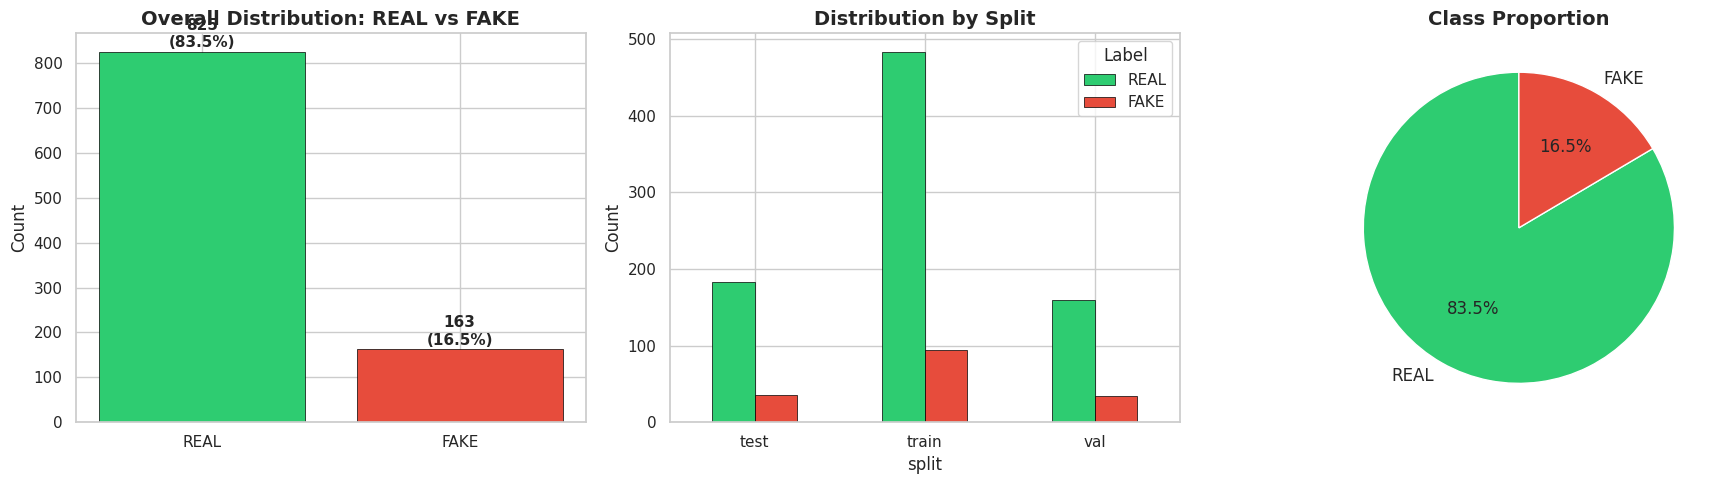


=== Detailed Counts ===
Total: 988 receipts
  REAL: 825 (83.5%)
  FAKE: 163 (16.5%)

Imbalance ratio: 5.06:1 (REAL:FAKE)

Per Split:
  train: 577 total | REAL: 483 | FAKE: 94
  test: 218 total | REAL: 183 | FAKE: 35
  val: 193 total | REAL: 159 | FAKE: 34


In [3]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Overall distribution
colors = {'REAL': '#2ecc71', 'FAKE': '#e74c3c'}
overall_counts = df['label'].value_counts()
axes[0].bar(overall_counts.index, overall_counts.values, 
            color=[colors[l] for l in overall_counts.index], edgecolor='black', linewidth=0.5)
axes[0].set_title('Overall Distribution: REAL vs FAKE', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count')
for i, (label, count) in enumerate(zip(overall_counts.index, overall_counts.values)):
    pct = count / len(df) * 100
    axes[0].text(i, count + 10, f'{count}\n({pct:.1f}%)', ha='center', fontsize=11, fontweight='bold')

# Distribution by split
split_label_counts = df.groupby(['split', 'label']).size().unstack(fill_value=0)
split_label_counts[['REAL', 'FAKE']].plot(kind='bar', ax=axes[1], 
    color=[colors['REAL'], colors['FAKE']], edgecolor='black', linewidth=0.5)
axes[1].set_title('Distribution by Split', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
axes[1].legend(title='Label')

# Pie chart
axes[2].pie(overall_counts.values, labels=overall_counts.index, 
            colors=[colors[l] for l in overall_counts.index],
            autopct='%1.1f%%', startangle=90, textprops={'fontsize': 12})
axes[2].set_title('Class Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print('\n=== Detailed Counts ===')
print(f'Total: {len(df)} receipts')
print(f'  REAL: {(df["label"]=="REAL").sum()} ({(df["label"]=="REAL").mean()*100:.1f}%)')
print(f'  FAKE: {(df["label"]=="FAKE").sum()} ({(df["label"]=="FAKE").mean()*100:.1f}%)')
print(f'\nImbalance ratio: {(df["label"]=="REAL").sum() / (df["label"]=="FAKE").sum():.2f}:1 (REAL:FAKE)')
print(f'\nPer Split:')
for split in ['train', 'test', 'val']:
    s = df[df['split'] == split]
    print(f'  {split}: {len(s)} total | REAL: {(s["label"]=="REAL").sum()} | FAKE: {(s["label"]=="FAKE").sum()}')

## 3. Annotation Analysis (Digital & Handwritten)

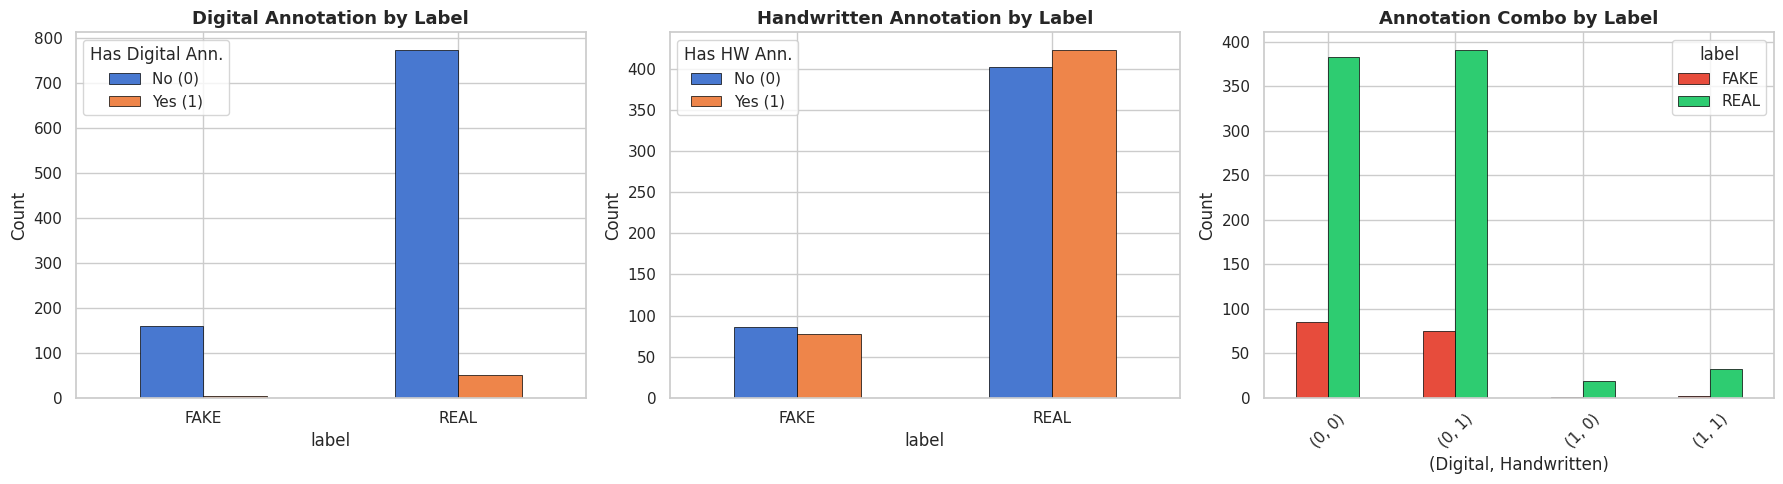

=== Annotation Statistics ===
Receipts with digital annotations: 54 (5.5%)
Receipts with handwritten annotations: 500 (50.6%)
Receipts with both: 34
Receipts with neither: 468


In [4]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Digital annotations distribution
digital_counts = df.groupby(['label', 'digital_annotation']).size().unstack(fill_value=0)
digital_counts.plot(kind='bar', ax=axes[0], edgecolor='black', linewidth=0.5)
axes[0].set_title('Digital Annotation by Label', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
axes[0].legend(title='Has Digital Ann.', labels=['No (0)', 'Yes (1)'])

# Handwritten annotations distribution
hw_counts = df.groupby(['label', 'handwritten_annotation']).size().unstack(fill_value=0)
hw_counts.plot(kind='bar', ax=axes[1], edgecolor='black', linewidth=0.5)
axes[1].set_title('Handwritten Annotation by Label', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
axes[1].legend(title='Has HW Ann.', labels=['No (0)', 'Yes (1)'])

# Combined annotations matrix
ann_combo = df.groupby(['digital_annotation', 'handwritten_annotation', 'label']).size().reset_index(name='count')
ann_pivot = ann_combo.pivot_table(index=['digital_annotation', 'handwritten_annotation'], 
                                   columns='label', values='count', fill_value=0)
ann_pivot.plot(kind='bar', ax=axes[2], color=[colors['FAKE'], colors['REAL']], 
               edgecolor='black', linewidth=0.5)
axes[2].set_title('Annotation Combo by Label', fontsize=13, fontweight='bold')
axes[2].set_ylabel('Count')
axes[2].set_xlabel('(Digital, Handwritten)')
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.savefig('../outputs/annotation_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print('=== Annotation Statistics ===')
print(f'Receipts with digital annotations: {df["digital_annotation"].sum()} ({df["digital_annotation"].mean()*100:.1f}%)')
print(f'Receipts with handwritten annotations: {df["handwritten_annotation"].sum()} ({df["handwritten_annotation"].mean()*100:.1f}%)')
print(f'Receipts with both: {((df["digital_annotation"]==1) & (df["handwritten_annotation"]==1)).sum()}')
print(f'Receipts with neither: {((df["digital_annotation"]==0) & (df["handwritten_annotation"]==0)).sum()}')

## 4. Forgery Annotation Analysis

In [5]:
def parse_forgery_annotations(raw_str):
    """Parse the forgery annotation string into a dictionary."""
    if raw_str == '0' or raw_str == 0 or pd.isna(raw_str):
        return None
    try:
        # Remove surrounding quotes if present
        raw_str = str(raw_str).strip('"')
        return ast.literal_eval(raw_str)
    except:
        return None

# Parse forgery annotations for forged receipts
df_forged = df[df['forged'] == 1].copy()
df_forged['annotations'] = df_forged['forgery_annotations_raw'].apply(parse_forgery_annotations)

# Extract forgery techniques and entity types
all_techniques = []
all_entity_types = []
all_software = []
regions_per_receipt = []

for _, row in df_forged.iterrows():
    ann = row['annotations']
    if ann and 'regions' in ann:
        regions = ann['regions']
        regions_per_receipt.append(len(regions))
        for region in regions:
            ra = region.get('region_attributes', {})
            # Extract technique
            modified_area = ra.get('Modified area', {})
            if isinstance(modified_area, dict):
                for technique, is_used in modified_area.items():
                    if is_used and technique != 'None':
                        all_techniques.append(technique)
            # Extract entity type
            entity = ra.get('Entity type', 'Unknown')
            all_entity_types.append(entity)
        # Software
        fa = ann.get('file_attributes', {})
        sw = fa.get('Software used', 'Unknown')
        all_software.append(sw)

print(f'Forged receipts with parsed annotations: {len(df_forged)}')
print(f'Total forgery regions: {sum(regions_per_receipt)}')
print(f'Average regions per forged receipt: {np.mean(regions_per_receipt):.1f}')
print(f'\nForgery techniques found: {Counter(all_techniques)}')
print(f'\nEntity types targeted: {Counter(all_entity_types)}')
print(f'\nSoftware used: {Counter(all_software)}')

Forged receipts with parsed annotations: 163
Total forgery regions: 622
Average regions per forged receipt: 4.1

Forgery techniques found: Counter({'CPI': 326, 'CUT': 42, 'IMI': 35, 'PIX': 33, 'CPO': 10, 'Autre': 8})

Entity types targeted: Counter({'Total/payment': 289, 'Product': 138, 'Metadata': 129, 'Company': 37, 'Other': 29})

Software used: Counter({'paint': 63, 'gimp': 62, 'aperçu': 15, 'paint3d': 10, 'kolourpaint': 3})


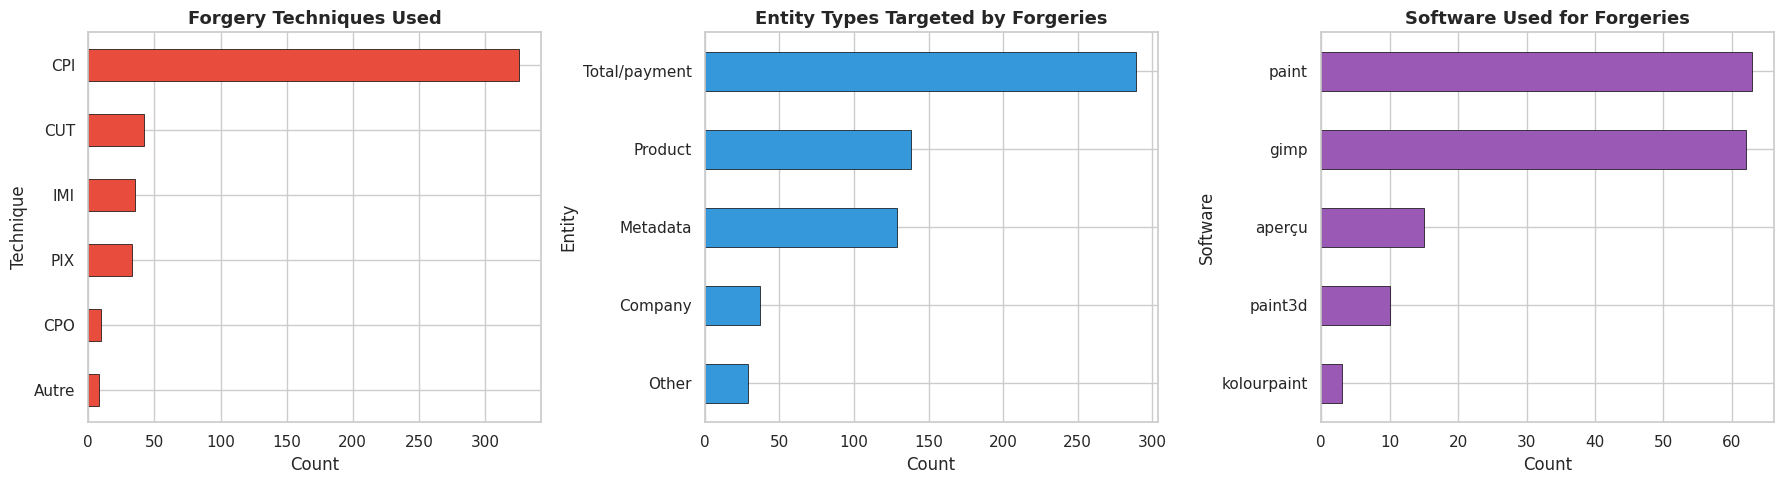

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Forgery techniques
tech_counts = Counter(all_techniques)
tech_df = pd.DataFrame(tech_counts.items(), columns=['Technique', 'Count']).sort_values('Count', ascending=True)
tech_df.plot(kind='barh', x='Technique', y='Count', ax=axes[0], 
             color='#e74c3c', edgecolor='black', linewidth=0.5, legend=False)
axes[0].set_title('Forgery Techniques Used', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Count')

# Entity types targeted
entity_counts = Counter(all_entity_types)
entity_df = pd.DataFrame(entity_counts.items(), columns=['Entity', 'Count']).sort_values('Count', ascending=True)
entity_df.plot(kind='barh', x='Entity', y='Count', ax=axes[1],
               color='#3498db', edgecolor='black', linewidth=0.5, legend=False)
axes[1].set_title('Entity Types Targeted by Forgeries', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Count')

# Software used
sw_counts = Counter(all_software)
sw_df = pd.DataFrame(sw_counts.items(), columns=['Software', 'Count']).sort_values('Count', ascending=True)
sw_df.plot(kind='barh', x='Software', y='Count', ax=axes[2],
           color='#9b59b6', edgecolor='black', linewidth=0.5, legend=False)
axes[2].set_title('Software Used for Forgeries', fontsize=13, fontweight='bold')
axes[2].set_xlabel('Count')

plt.tight_layout()
plt.savefig('../outputs/forgery_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

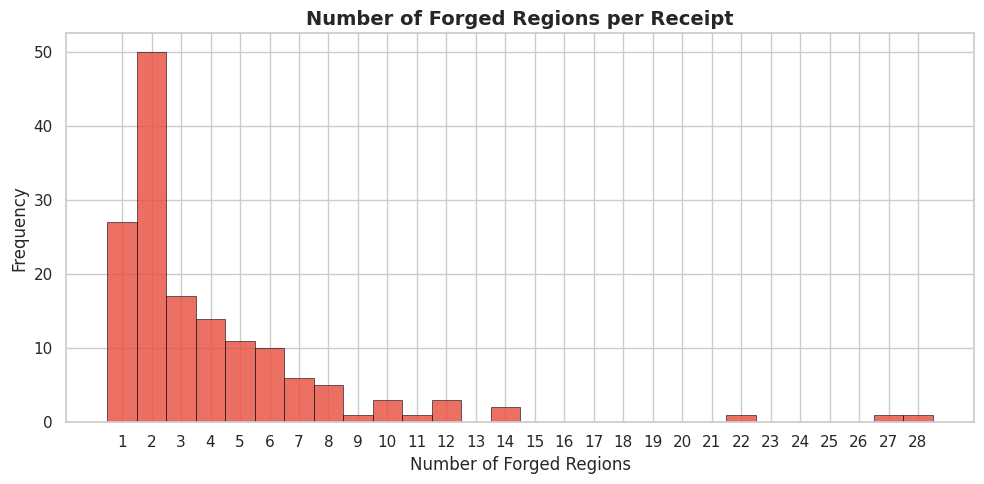

Min regions per receipt: 1
Max regions per receipt: 28
Median regions per receipt: 2.0
Distribution: Counter({2: 50, 1: 27, 3: 17, 4: 14, 5: 11, 6: 10, 7: 6, 8: 5, 10: 3, 12: 3, 14: 2, 11: 1, 9: 1, 27: 1, 22: 1, 28: 1})


In [7]:
# Regions per forged receipt distribution
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(regions_per_receipt, bins=range(1, max(regions_per_receipt)+2), 
        color='#e74c3c', edgecolor='black', linewidth=0.5, alpha=0.8, align='left')
ax.set_title('Number of Forged Regions per Receipt', fontsize=14, fontweight='bold')
ax.set_xlabel('Number of Forged Regions')
ax.set_ylabel('Frequency')
ax.set_xticks(range(1, max(regions_per_receipt)+1))
plt.tight_layout()
plt.savefig('../outputs/regions_per_receipt.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'Min regions per receipt: {min(regions_per_receipt)}')
print(f'Max regions per receipt: {max(regions_per_receipt)}')
print(f'Median regions per receipt: {np.median(regions_per_receipt)}')
print(f'Distribution: {Counter(regions_per_receipt)}')

## 5. Image Properties Analysis

In [8]:
# Collect image properties
img_props = []
for _, row in df.iterrows():
    img_path = DATA_ROOT / row['split'] / row['image']
    if img_path.exists():
        try:
            with Image.open(img_path) as img:
                w, h = img.size
                file_size = os.path.getsize(img_path)
                img_props.append({
                    'image': row['image'],
                    'split': row['split'],
                    'label': row['label'],
                    'width': w,
                    'height': h,
                    'aspect_ratio': w / h,
                    'pixels': w * h,
                    'file_size_kb': file_size / 1024,
                    'mode': img.mode
                })
        except Exception as e:
            print(f'Error reading {img_path}: {e}')

df_img = pd.DataFrame(img_props)
print(f'Successfully loaded properties for {len(df_img)} images')
print(f'\n=== Image Size Statistics ===')
print(df_img[['width', 'height', 'file_size_kb', 'aspect_ratio']].describe().round(2))
print(f'\n=== Image Modes ===')
print(df_img['mode'].value_counts())

Successfully loaded properties for 987 images

=== Image Size Statistics ===
         width   height  file_size_kb  aspect_ratio
count   987.00   987.00        987.00        987.00
mean   1363.88  2407.57       1048.18          0.52
std    1449.42  1886.25       3745.54          0.12
min     435.00   605.00         32.14          0.26
25%     627.00  1399.50        328.35          0.42
50%     818.00  1698.00        567.81          0.50
75%     935.00  2168.00       1015.81          0.59
max    4961.00  7016.00      68105.05          0.97

=== Image Modes ===
mode
L       542
RGB     342
RGBA     89
LA       14
Name: count, dtype: int64


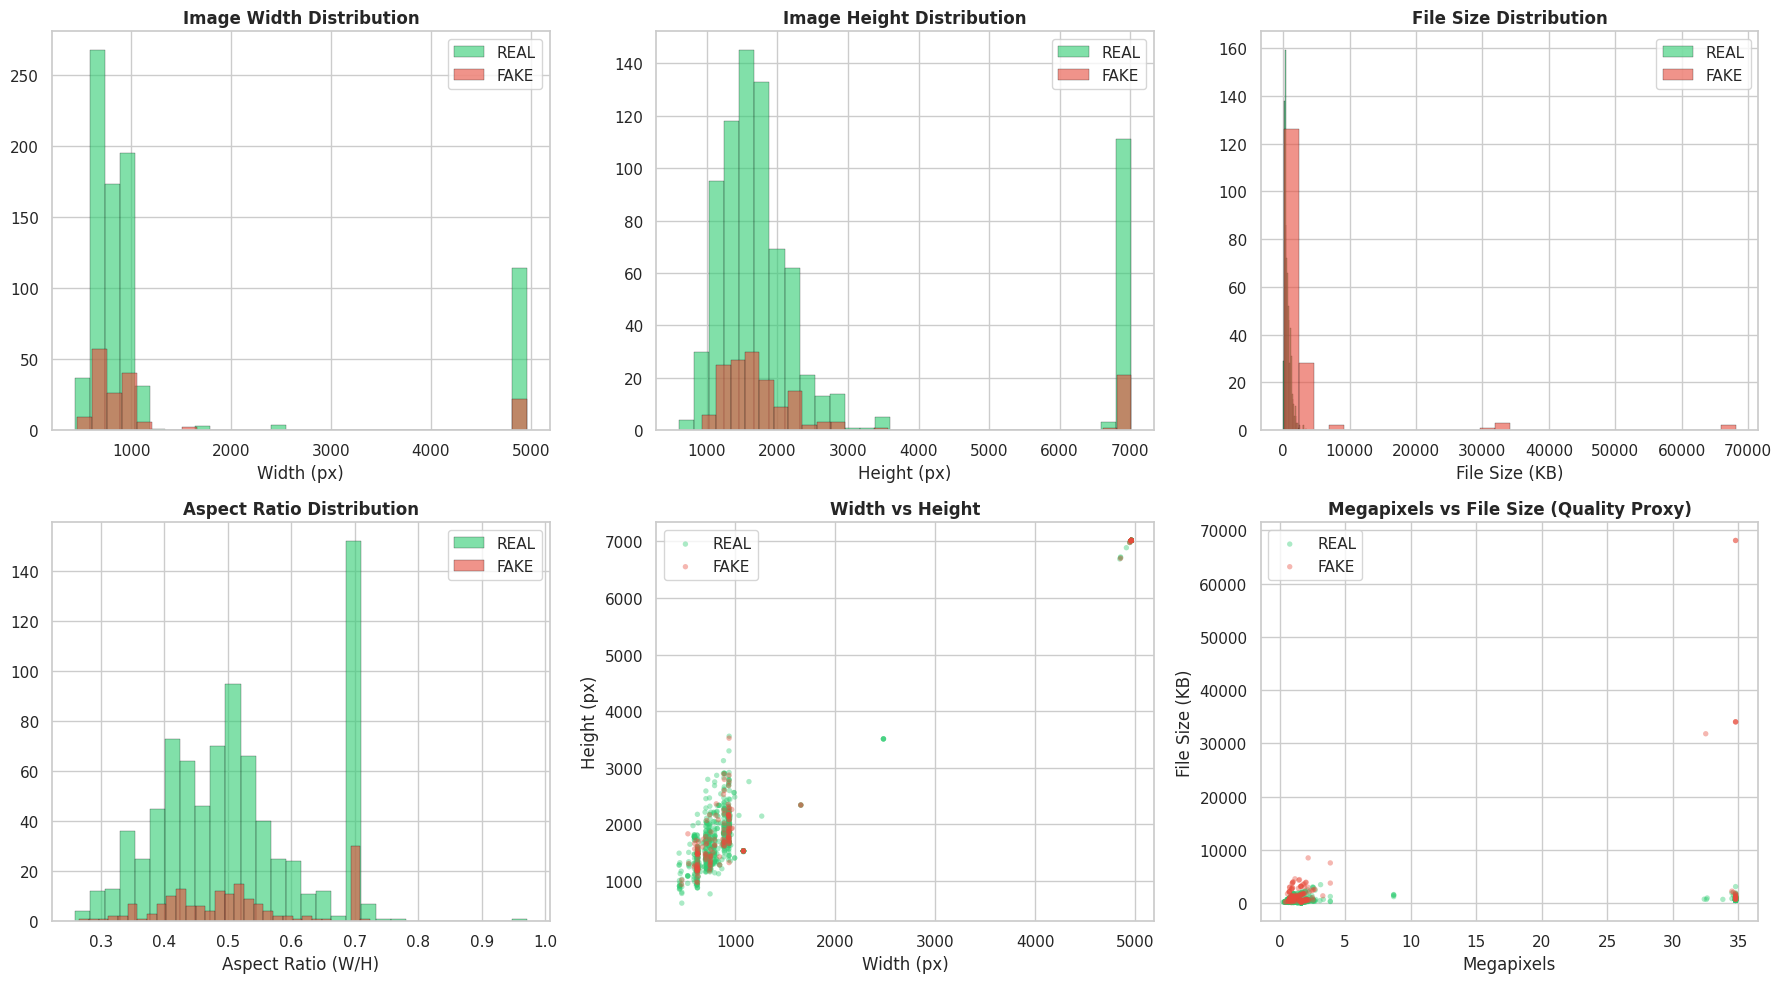

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Width distribution by label
for label in ['REAL', 'FAKE']:
    subset = df_img[df_img['label'] == label]
    axes[0, 0].hist(subset['width'], bins=30, alpha=0.6, label=label, color=colors[label], edgecolor='black', linewidth=0.3)
axes[0, 0].set_title('Image Width Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Width (px)')
axes[0, 0].legend()

# Height distribution by label
for label in ['REAL', 'FAKE']:
    subset = df_img[df_img['label'] == label]
    axes[0, 1].hist(subset['height'], bins=30, alpha=0.6, label=label, color=colors[label], edgecolor='black', linewidth=0.3)
axes[0, 1].set_title('Image Height Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Height (px)')
axes[0, 1].legend()

# File size distribution by label
for label in ['REAL', 'FAKE']:
    subset = df_img[df_img['label'] == label]
    axes[0, 2].hist(subset['file_size_kb'], bins=30, alpha=0.6, label=label, color=colors[label], edgecolor='black', linewidth=0.3)
axes[0, 2].set_title('File Size Distribution', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('File Size (KB)')
axes[0, 2].legend()

# Aspect ratio distribution
for label in ['REAL', 'FAKE']:
    subset = df_img[df_img['label'] == label]
    axes[1, 0].hist(subset['aspect_ratio'], bins=30, alpha=0.6, label=label, color=colors[label], edgecolor='black', linewidth=0.3)
axes[1, 0].set_title('Aspect Ratio Distribution', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Aspect Ratio (W/H)')
axes[1, 0].legend()

# Width vs Height scatter
for label in ['REAL', 'FAKE']:
    subset = df_img[df_img['label'] == label]
    axes[1, 1].scatter(subset['width'], subset['height'], alpha=0.4, 
                       label=label, color=colors[label], s=15, edgecolor='none')
axes[1, 1].set_title('Width vs Height', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Width (px)')
axes[1, 1].set_ylabel('Height (px)')
axes[1, 1].legend()

# File size vs Pixel count (quality proxy)
for label in ['REAL', 'FAKE']:
    subset = df_img[df_img['label'] == label]
    axes[1, 2].scatter(subset['pixels'] / 1e6, subset['file_size_kb'], alpha=0.4,
                       label=label, color=colors[label], s=15, edgecolor='none')
axes[1, 2].set_title('Megapixels vs File Size (Quality Proxy)', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('Megapixels')
axes[1, 2].set_ylabel('File Size (KB)')
axes[1, 2].legend()

plt.tight_layout()
plt.savefig('../outputs/image_properties.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Receipt Text Content Analysis

In [10]:
import re

# Load receipt transcriptions
text_data = []
for _, row in df.iterrows():
    txt_path = DATA_ROOT / row['split'] / row['image'].replace('.png', '.txt')
    if txt_path.exists():
        with open(txt_path, 'r', encoding='utf-8', errors='ignore') as f:
            content = f.read()
        
        # Extract monetary values (RM or just numbers with decimals)
        amounts = re.findall(r'\b\d+\.\d{2}\b', content)
        amounts_float = [float(a) for a in amounts]
        
        # Find total-related lines
        total_match = re.search(r'(?:TOTAL|AMOUNT|PAYMENT)[:\s]*[RM\s]*(\d+\.\d{2})', content, re.IGNORECASE)
        total_value = float(total_match.group(1)) if total_match else None
        
        text_data.append({
            'image': row['image'],
            'split': row['split'],
            'label': row['label'],
            'text': content,
            'text_length': len(content),
            'line_count': content.count('\n') + 1,
            'word_count': len(content.split()),
            'amounts_found': amounts_float,
            'num_amounts': len(amounts_float),
            'max_amount': max(amounts_float) if amounts_float else None,
            'total_value': total_value
        })

df_text = pd.DataFrame(text_data)
print(f'Loaded text data for {len(df_text)} receipts')
print(f'\n=== Text Content Statistics ===')
print(df_text[['text_length', 'line_count', 'word_count', 'num_amounts']].describe().round(1))
print(f'\nReceipts with detected total: {df_text["total_value"].notna().sum()} ({df_text["total_value"].notna().mean()*100:.1f}%)')

Loaded text data for 987 receipts

=== Text Content Statistics ===
       text_length  line_count  word_count  num_amounts
count        987.0       987.0       987.0        987.0
mean         670.1        54.7       115.0         12.1
std          187.8        17.7        33.0          6.1
min          188.0        19.0        27.0          0.0
25%          538.0        43.0        91.0          9.0
50%          632.0        51.0       109.0         11.0
75%          768.0        64.0       132.0         15.0
max         2352.0       154.0       240.0         53.0

Receipts with detected total: 574 (58.2%)


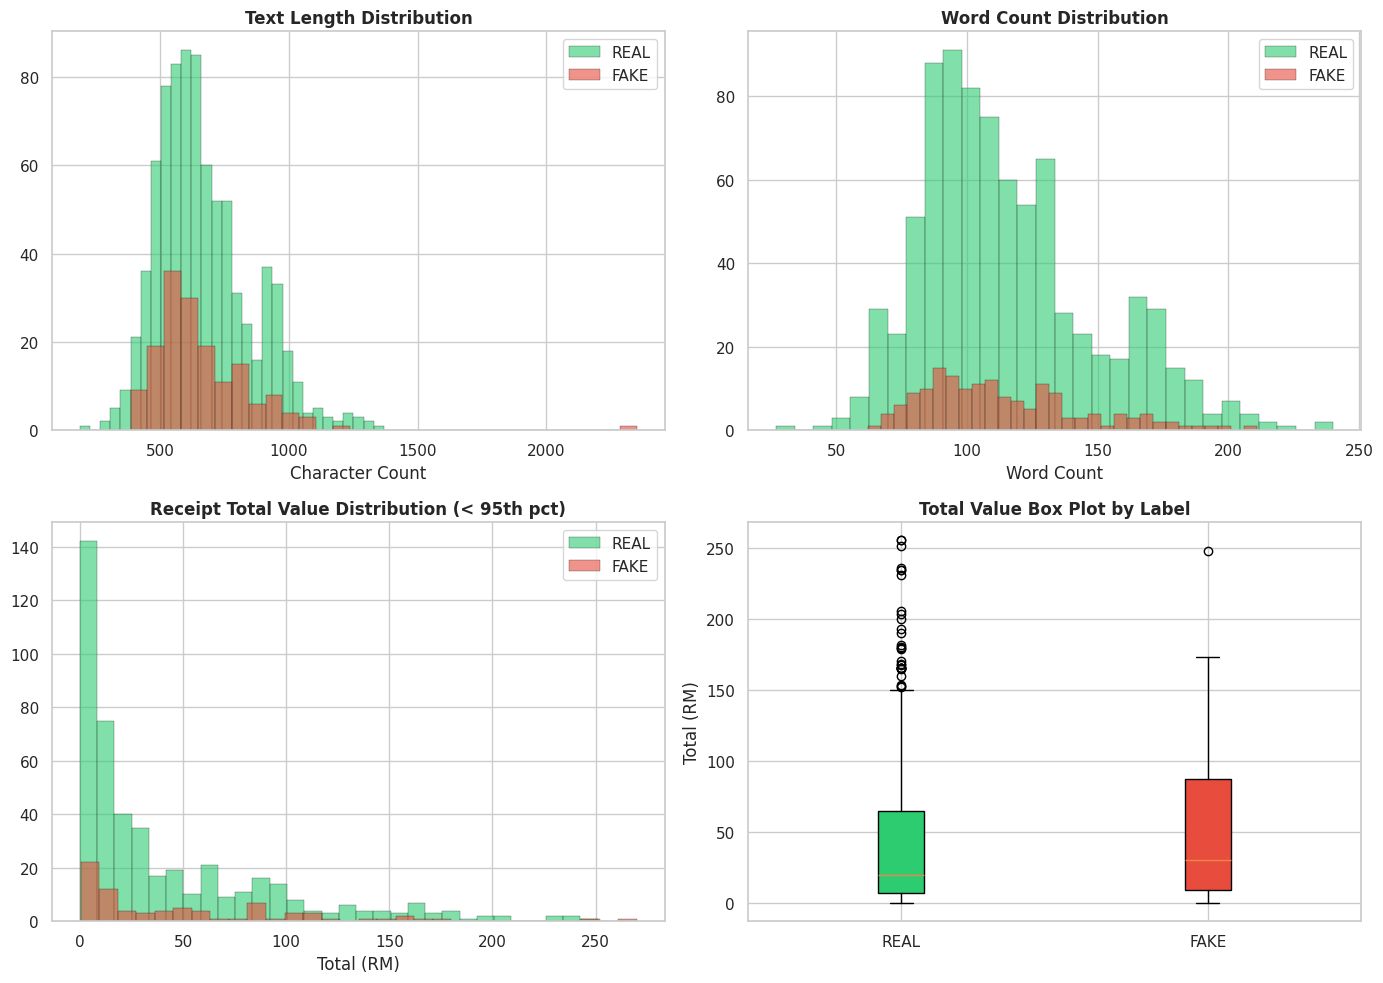

=== Total Value Statistics ===

REAL:
  Count with detected total: 490
  Mean: RM 60.77
  Median: RM 22.22
  Min: RM 0.00
  Max: RM 848.00

FAKE:
  Count with detected total: 84
  Mean: RM 74.63
  Median: RM 38.85
  Min: RM 0.34
  Max: RM 593.10


In [11]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Text length distribution
for label in ['REAL', 'FAKE']:
    subset = df_text[df_text['label'] == label]
    axes[0, 0].hist(subset['text_length'], bins=30, alpha=0.6, label=label, color=colors[label], edgecolor='black', linewidth=0.3)
axes[0, 0].set_title('Text Length Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Character Count')
axes[0, 0].legend()

# Word count distribution
for label in ['REAL', 'FAKE']:
    subset = df_text[df_text['label'] == label]
    axes[0, 1].hist(subset['word_count'], bins=30, alpha=0.6, label=label, color=colors[label], edgecolor='black', linewidth=0.3)
axes[0, 1].set_title('Word Count Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Word Count')
axes[0, 1].legend()

# Total values distribution (for those detected)
df_with_total = df_text[df_text['total_value'].notna()]
for label in ['REAL', 'FAKE']:
    subset = df_with_total[df_with_total['label'] == label]
    if len(subset) > 0:
        # Filter out extreme outliers for better visualization
        vals = subset['total_value']
        vals = vals[vals < vals.quantile(0.95)]
        axes[1, 0].hist(vals, bins=30, alpha=0.6, label=label, color=colors[label], edgecolor='black', linewidth=0.3)
axes[1, 0].set_title('Receipt Total Value Distribution (< 95th pct)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Total (RM)')
axes[1, 0].legend()

# Box plot of total values by label
df_box = df_with_total[df_with_total['total_value'] < df_with_total['total_value'].quantile(0.95)]
data_real = df_box[df_box['label'] == 'REAL']['total_value'].dropna()
data_fake = df_box[df_box['label'] == 'FAKE']['total_value'].dropna()
bp = axes[1, 1].boxplot([data_real, data_fake], labels=['REAL', 'FAKE'], patch_artist=True)
bp['boxes'][0].set_facecolor(colors['REAL'])
bp['boxes'][1].set_facecolor(colors['FAKE'])
axes[1, 1].set_title('Total Value Box Plot by Label', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Total (RM)')

plt.tight_layout()
plt.savefig('../outputs/text_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print('=== Total Value Statistics ===')
for label in ['REAL', 'FAKE']:
    subset = df_with_total[df_with_total['label'] == label]
    print(f'\n{label}:')
    print(f'  Count with detected total: {len(subset)}')
    print(f'  Mean: RM {subset["total_value"].mean():.2f}')
    print(f'  Median: RM {subset["total_value"].median():.2f}')
    print(f'  Min: RM {subset["total_value"].min():.2f}')
    print(f'  Max: RM {subset["total_value"].max():.2f}')

## 7. Sample Receipt Visualization

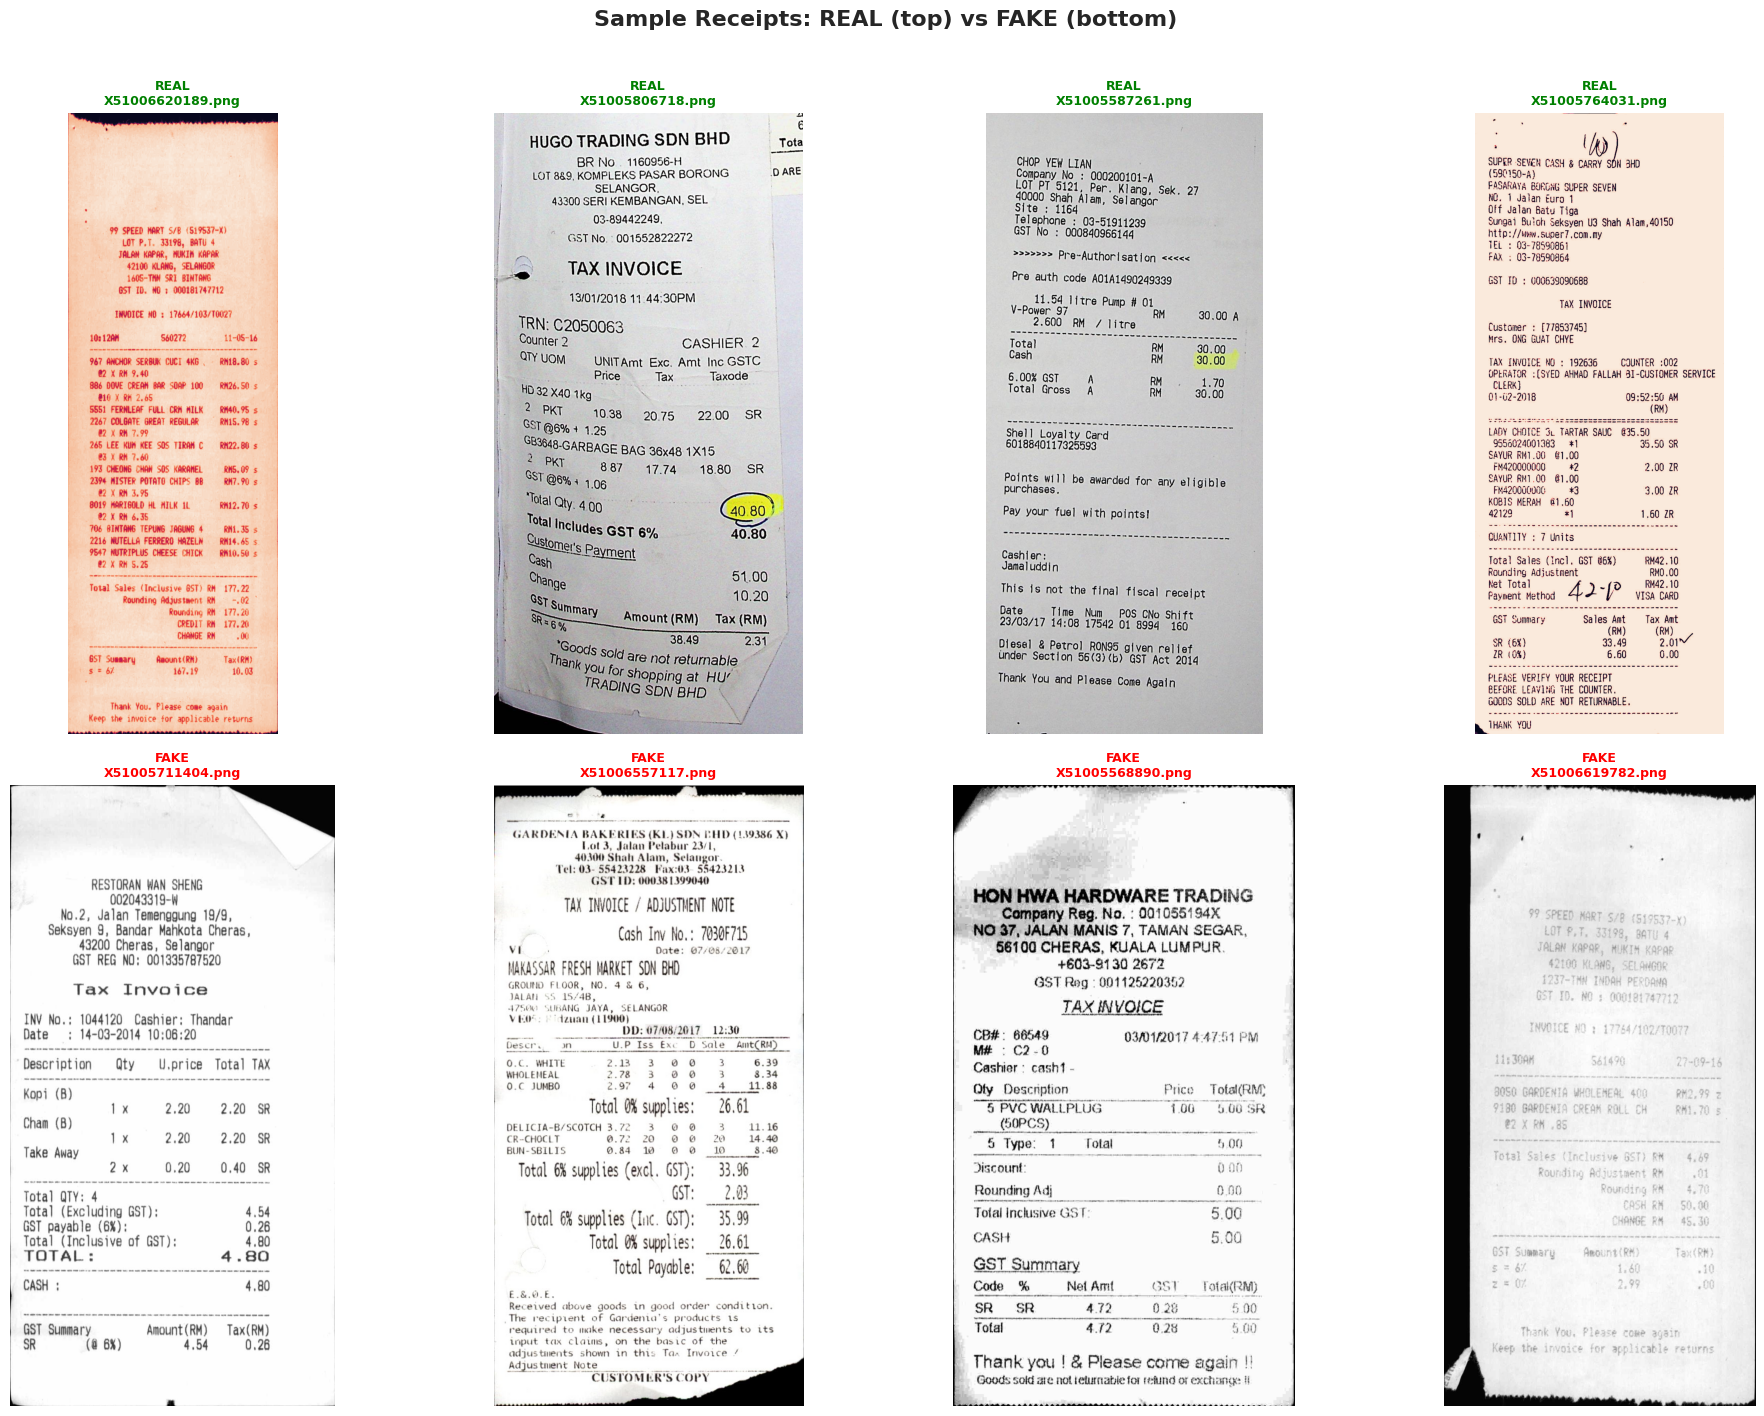

In [12]:
# Show sample real and fake receipts side by side
real_samples = df[df['label'] == 'REAL'].sample(n=4, random_state=42)
fake_samples = df[df['label'] == 'FAKE'].sample(n=4, random_state=42)

fig, axes = plt.subplots(2, 4, figsize=(20, 14))
fig.suptitle('Sample Receipts: REAL (top) vs FAKE (bottom)', fontsize=16, fontweight='bold', y=1.01)

for i, (_, row) in enumerate(real_samples.iterrows()):
    img_path = DATA_ROOT / row['split'] / row['image']
    img = Image.open(img_path)
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'REAL\n{row["image"]}', fontsize=9, color='green', fontweight='bold')
    axes[0, i].axis('off')

for i, (_, row) in enumerate(fake_samples.iterrows()):
    img_path = DATA_ROOT / row['split'] / row['image']
    img = Image.open(img_path)
    axes[1, i].imshow(img)
    axes[1, i].set_title(f'FAKE\n{row["image"]}', fontsize=9, color='red', fontweight='bold')
    axes[1, i].axis('off')

plt.tight_layout()
plt.savefig('../outputs/sample_receipts.png', dpi=150, bbox_inches='tight')
plt.show()

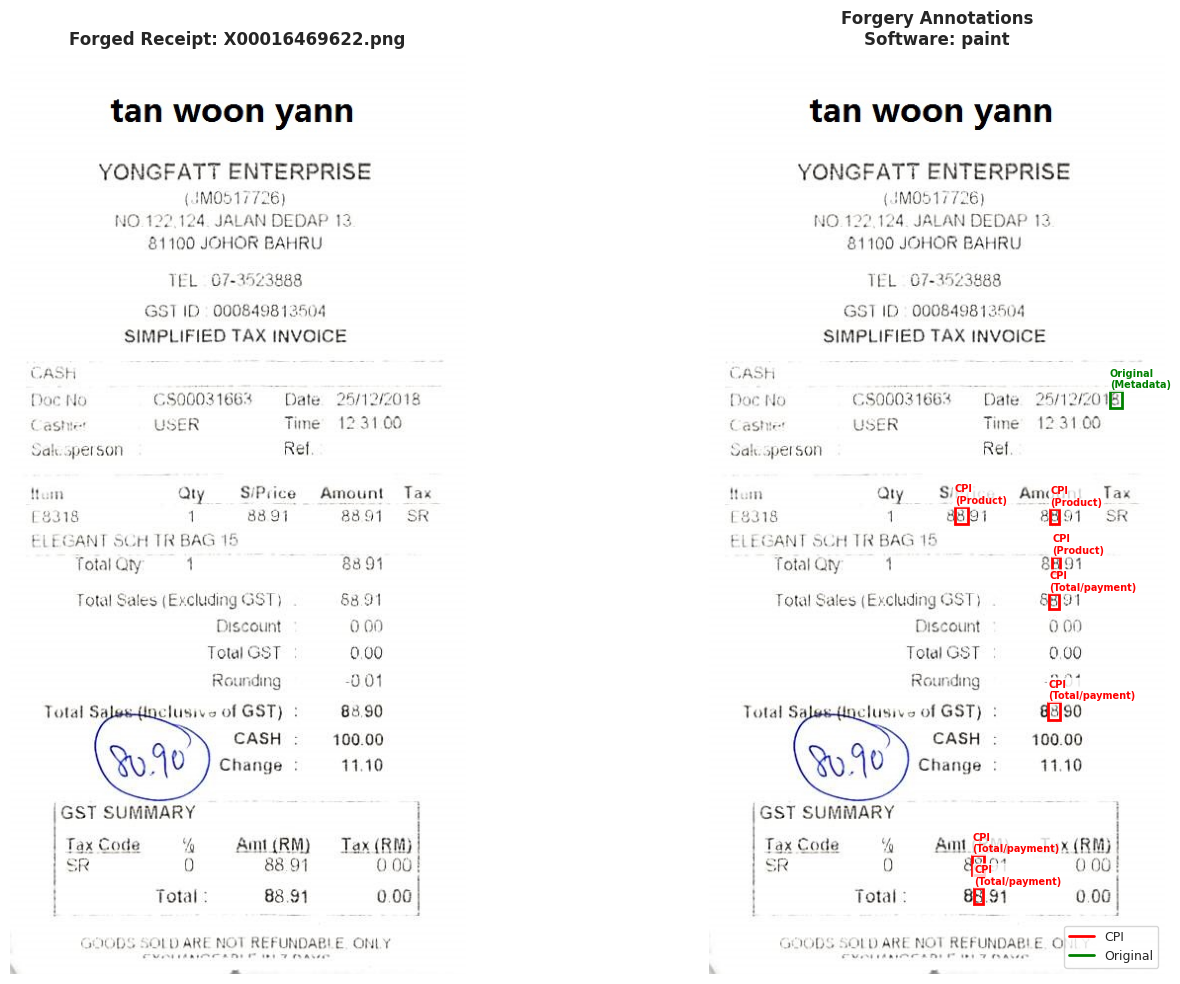


Forged Receipt: X00016469622.png
Software used: paint
Number of forgery regions: 8
  Region 1: Entity=Product | Technique={'CPI': True} | Original=no | BBox=(248,459,13,18)
  Region 2: Entity=Metadata | Technique={'None': True} | Original=yes | BBox=(405,342,13,17)
  Region 3: Entity=Product | Technique={'CPI': True} | Original=no | BBox=(345,461,9,16)
  Region 4: Entity=Product | Technique={'CPI': True} | Original=no | BBox=(347,510,8,16)
  Region 5: Entity=Total/payment | Technique={'CPI': True} | Original=no | BBox=(344,547,10,16)
  Region 6: Entity=Total/payment | Technique={'CPI': True} | Original=no | BBox=(343,657,12,18)
  Region 7: Entity=Total/payment | Technique={'CPI': True} | Original=no | BBox=(266,812,12,20)
  Region 8: Entity=Total/payment | Technique={'CPI': True} | Original=no | BBox=(268,845,9,17)


In [13]:
# Detailed view of a forged receipt with its annotation bounding boxes
forged_sample = df_forged[df_forged['annotations'].notna()].iloc[0]
img_path = DATA_ROOT / forged_sample['split'] / forged_sample['image']
ann = forged_sample['annotations']

fig, axes = plt.subplots(1, 2, figsize=(16, 10))

# Original image
img = Image.open(img_path)
axes[0].imshow(img)
axes[0].set_title(f'Forged Receipt: {forged_sample["image"]}', fontsize=12, fontweight='bold')
axes[0].axis('off')

# Image with bounding boxes
axes[1].imshow(img)
from matplotlib.patches import Rectangle

technique_colors = {'CPI': 'red', 'CUT': 'blue', 'IMI': 'orange', 'DEL': 'purple', 'PIX': 'cyan'}
legend_entries = {}

for region in ann['regions']:
    sa = region['shape_attributes']
    ra = region['region_attributes']
    
    # Determine technique
    modified_area = ra.get('Modified area', {})
    is_original = ra.get('Original area', 'no') == 'yes'
    
    if is_original:
        color = 'green'
        tech_label = 'Original'
    else:
        techniques = [k for k, v in modified_area.items() if v and k != 'None']
        tech_label = '+'.join(techniques) if techniques else 'Unknown'
        color = technique_colors.get(techniques[0] if techniques else '', 'yellow')
    
    rect = Rectangle((sa['x'], sa['y']), sa['width'], sa['height'],
                      linewidth=2, edgecolor=color, facecolor='none', linestyle='-')
    axes[1].add_patch(rect)
    
    entity = ra.get('Entity type', '')
    axes[1].text(sa['x'], sa['y'] - 3, f'{tech_label}\n({entity})', 
                fontsize=7, color=color, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.1', facecolor='white', alpha=0.8))
    legend_entries[tech_label] = color

axes[1].set_title(f'Forgery Annotations\nSoftware: {ann["file_attributes"].get("Software used", "N/A")}', 
                  fontsize=12, fontweight='bold')
axes[1].axis('off')

# Add legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color=c, linewidth=2, label=l) for l, c in legend_entries.items()]
axes[1].legend(handles=legend_elements, loc='lower right', fontsize=9)

plt.tight_layout()
plt.savefig('../outputs/forgery_bbox_example.png', dpi=150, bbox_inches='tight')
plt.show()

# Print annotation details
print(f'\nForged Receipt: {forged_sample["image"]}')
print(f'Software used: {ann["file_attributes"].get("Software used", "N/A")}')
print(f'Number of forgery regions: {len(ann["regions"])}')
for i, region in enumerate(ann['regions']):
    ra = region['region_attributes']
    sa = region['shape_attributes']
    print(f'  Region {i+1}: Entity={ra.get("Entity type", "?")} | '
          f'Technique={ra.get("Modified area", {})} | '
          f'Original={ra.get("Original area", "?")} | '
          f'BBox=({sa["x"]},{sa["y"]},{sa["width"]},{sa["height"]})')

## 8. Summary Statistics and Key Insights

In [14]:
print('=' * 70)
print('DATASET EXPLORATION SUMMARY')
print('=' * 70)

print(f'\n1. DATASET SIZE & SPLITS')
print(f'   Total receipts: {len(df)}')
print(f'   Train: {len(df_train)} | Test: {len(df_test)} | Val: {len(df_val)}')

print(f'\n2. CLASS DISTRIBUTION')
print(f'   REAL: {(df["label"]=="REAL").sum()} ({(df["label"]=="REAL").mean()*100:.1f}%)')
print(f'   FAKE: {(df["label"]=="FAKE").sum()} ({(df["label"]=="FAKE").mean()*100:.1f}%)')
print(f'   Class imbalance ratio: {(df["label"]=="REAL").sum()/(df["label"]=="FAKE").sum():.1f}:1')

print(f'\n3. FORGERY CHARACTERISTICS')
print(f'   Total forged regions: {sum(regions_per_receipt)}')
print(f'   Avg regions/receipt: {np.mean(regions_per_receipt):.1f}')
print(f'   Most common technique: {tech_counts.most_common(1)[0][0]} ({tech_counts.most_common(1)[0][1]} instances)')
print(f'   Most targeted entity: {entity_counts.most_common(1)[0][0]} ({entity_counts.most_common(1)[0][1]} instances)')

print(f'\n4. IMAGE PROPERTIES')
print(f'   Width range: {df_img["width"].min()}-{df_img["width"].max()} px')
print(f'   Height range: {df_img["height"].min()}-{df_img["height"].max()} px')
print(f'   File size range: {df_img["file_size_kb"].min():.0f}-{df_img["file_size_kb"].max():.0f} KB')
print(f'   Mean file size: {df_img["file_size_kb"].mean():.0f} KB')

print(f'\n5. TEXT CONTENT')
print(f'   Avg text length: {df_text["text_length"].mean():.0f} chars')
print(f'   Avg word count: {df_text["word_count"].mean():.0f} words')
print(f'   Receipts with detectable total: {df_text["total_value"].notna().sum()}')

print(f'\n6. KEY OBSERVATIONS')
print(f'   - Dataset is significantly imbalanced (~5:1 REAL:FAKE)')
print(f'   - Malaysian receipts with RM currency (from SROIE)')
print(f'   - Forgeries target primarily monetary fields (Total/payment, Product)')
print(f'   - CPI (Copy-Paste Imitation) is the dominant forgery technique')
print(f'   - Forgeries are subtle (small bounding boxes, pixel-level changes)')
print(f'   - Both image and text modalities available for analysis')
print(f'   - Some authentic receipts have annotations (handwritten/digital) that are NOT forgeries')
print('\n' + '=' * 70)

DATASET EXPLORATION SUMMARY

1. DATASET SIZE & SPLITS
   Total receipts: 988
   Train: 577 | Test: 218 | Val: 193

2. CLASS DISTRIBUTION
   REAL: 825 (83.5%)
   FAKE: 163 (16.5%)
   Class imbalance ratio: 5.1:1

3. FORGERY CHARACTERISTICS
   Total forged regions: 622
   Avg regions/receipt: 4.1
   Most common technique: CPI (326 instances)
   Most targeted entity: Total/payment (289 instances)

4. IMAGE PROPERTIES
   Width range: 435-4961 px
   Height range: 605-7016 px
   File size range: 32-68105 KB
   Mean file size: 1048 KB

5. TEXT CONTENT
   Avg text length: 670 chars
   Avg word count: 115 words
   Receipts with detectable total: 574

6. KEY OBSERVATIONS
   - Dataset is significantly imbalanced (~5:1 REAL:FAKE)
   - Malaysian receipts with RM currency (from SROIE)
   - Forgeries target primarily monetary fields (Total/payment, Product)
   - CPI (Copy-Paste Imitation) is the dominant forgery technique
   - Forgeries are subtle (small bounding boxes, pixel-level changes)
   - Both